<a href="https://colab.research.google.com/github/Ah-ae/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (21.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and direc

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [5]:
!unzip tpss_bcycl_od_statnhm_202504.zip -d tpss_bcycl_od_statnhm_202504

Archive:  tpss_bcycl_od_statnhm_202504.zip
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250416.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250417.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250419.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250418.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250413.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250410.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250411.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250415.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250414.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250412.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250405.csv  
  inflating: tpss_bcycl_od_statnhm_202504/tpss_bcycl_od_statnhm_20250408.csv  
  inflati

## 12-2 CSV 형태의 데이터 수집

In [6]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202504/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949') # 윈도우 환경에서 만들어진 파일이기 때문에 윈도우 환경 인코딩 옵션 지정
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20250427,출발시간,2100,ST-3094,등촌1동_003_1,ST-1510,등촌1동_043_1,1,2.0,381.0
1,20250427,출발시간,900,ST-244,왕십리도선동_039_1,ST-272,용신동_047_1,1,85.0,1100.0
2,20250427,출발시간,1610,ST-1390,수유2동_030_1,ST-650,수유3동_017_1,1,4.0,605.0
3,20250427,출발시간,1735,ST-513,가양1동_025_1,ST-514,가양1동_011_1,1,3.0,715.0
4,20250427,출발시간,1000,ST-3061,여의동_051_2,ST-2814,여의동_037_1,1,14.0,1697.0


In [7]:
df

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20250427,출발시간,2100,ST-3094,등촌1동_003_1,ST-1510,등촌1동_043_1,1,2.0,381.0
1,20250427,출발시간,900,ST-244,왕십리도선동_039_1,ST-272,용신동_047_1,1,85.0,1100.0
2,20250427,출발시간,1610,ST-1390,수유2동_030_1,ST-650,수유3동_017_1,1,4.0,605.0
3,20250427,출발시간,1735,ST-513,가양1동_025_1,ST-514,가양1동_011_1,1,3.0,715.0
4,20250427,출발시간,1000,ST-3061,여의동_051_2,ST-2814,여의동_037_1,1,14.0,1697.0
...,...,...,...,...,...,...,...,...,...,...
6723594,20250422,도착시간,1815,ST-1326,한강로동_013_1,ST-750,반포3동_015_5,1,27.0,5140.0
6723595,20250422,도착시간,2040,ST-1275,구로5동_040_1,ST-1220,구로5동_039_1,1,7.0,610.0
6723596,20250422,도착시간,2035,ST-62,여의동_017_1,ST-62,여의동_017_1,1,99.0,1324.0
6723597,20250422,도착시간,1625,ST-827,안암동_015_1,ST-3333,용신동_044_2,1,7.0,616.0


## 12-3 기초 통계량 산출

In [9]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())

## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |   기준_날짜 |   기준_시간대 |   전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|--------------:|------------:|---------------:|-----------------:|
| count | 6.7236e+06  |    6.7236e+06 |  6.7236e+06 |    6.51207e+06 |      6.51207e+06 |
| mean  | 2.02504e+07 | 1424.08       |  1.06081    |   23.4802      |   2733.69        |
| std   | 8.92047     |  557.281      |  0.276361   |   31.0741      |   3537.67        |
| min   | 2.02504e+07 |    0          |  1          |    1           |    300           |
| 25%   | 2.02504e+07 |  940          |  1          |    6           |    906           |
| 50%   | 2.02504e+07 | 1530          |  1          |   12           |   1577           |
| 75%   | 2.02504e+07 | 1845          |  1          |   28           |   3010           |
| max   | 2.02504e+07 | 2355          | 17          | 2028           | 162307           |
범주형 데이터 요약 통계:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |
|:-------|:--------

## 12-4 결측치 및 이상치 제거

In [12]:
## 결측치 제거
df = df.dropna()

## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]

## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]

## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

In [13]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())

## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |   기준_날짜 |    기준_시간대 |   전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|------------:|---------------:|-----------------:|
| count | 3.09336e+06 |    3.09336e+06 | 3.09336e+06 |    3.09336e+06 |      3.09336e+06 |
| mean  | 2.02504e+07 | 1402.65        | 1.04682     |   19.9563      |   2172.11        |
| std   | 8.92642     |  557.186       | 0.233368    |   22.4369      |   1882.57        |
| min   | 2.02504e+07 |    0           | 1           |    2           |    300           |
| 25%   | 2.02504e+07 |  925           | 1           |    6           |    890           |
| 50%   | 2.02504e+07 | 1515           | 1           |   12           |   1512           |
| 75%   | 2.02504e+07 | 1835           | 1           |   24           |   2730           |
| max   | 2.02504e+07 | 2355           | 9           |  179           |   9999           |
범주형 데이터 요약 통계:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |
|:-------

## 12-5 날짜/시간 데이터 형식 변환

In [14]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')

## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

In [15]:
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
0,2025-04-27,출발시간,2100,ST-3094,등촌1동_003_1,ST-1510,등촌1동_043_1,1,2.0,381.0,일요일
1,2025-04-27,출발시간,900,ST-244,왕십리도선동_039_1,ST-272,용신동_047_1,1,85.0,1100.0,일요일
2,2025-04-27,출발시간,1610,ST-1390,수유2동_030_1,ST-650,수유3동_017_1,1,4.0,605.0,일요일
3,2025-04-27,출발시간,1735,ST-513,가양1동_025_1,ST-514,가양1동_011_1,1,3.0,715.0,일요일
4,2025-04-27,출발시간,1000,ST-3061,여의동_051_2,ST-2814,여의동_037_1,1,14.0,1697.0,일요일


## 전처리 결과 확인

In [16]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |    기준_시간대 |   전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|---------------:|------------:|---------------:|-----------------:|
| count | 3093355                       |    3.09336e+06 | 3.09336e+06 |    3.09336e+06 |      3.09336e+06 |
| mean  | 2025-04-16 05:33:40.518047744 | 1402.65        | 1.04682     |   19.9563      |   2172.11        |
| min   | 2025-04-01 00:00:00           |    0           | 1           |    2           |    300           |
| 25%   | 2025-04-08 00:00:00           |  925           | 1           |    6           |    890           |
| 50%   | 2025-04-17 00:00:00           | 1515           | 1           |   12           |   1512           |
| 75%   | 2025-04-24 00:00:00           | 1835           | 1           |   24           |   2730           |
| max   | 2025-04-30 00:00:00           | 2355           | 9           |  179           |   9999           |
| std   | nan              

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [17]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())

## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    424965
화요일    524974
수요일    615939
목요일    503336
금요일    512405
토요일    202124
일요일    309612
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

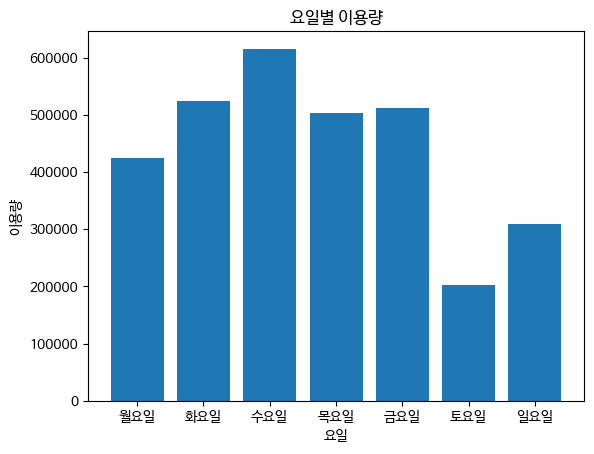

In [19]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)

plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

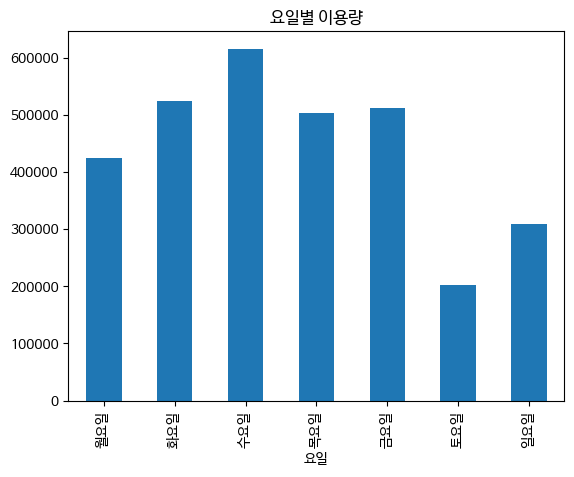

In [21]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.title('요일별 이용량')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0      56075
1      39547
2      26632
3      19085
4      16728
5      32313
6      72041
7     182990
8     264597
9     144110
10    111974
11    128125
12    141286
13    136786
14    135162
15    153060
16    190797
17    257999
18    314659
19    193088
20    155610
21    142733
22    119665
23     58293
Name: count, dtype: int64


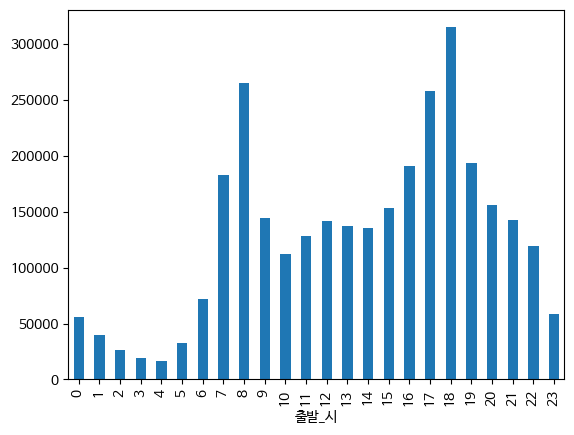

In [22]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대'] // 100

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2025-04-01    112403
2025-04-02    100310
2025-04-03    111386
2025-04-04    112966
2025-04-05     15120
2025-04-06     79874
2025-04-07    120194
2025-04-08    126956
2025-04-09    108749
2025-04-10    129019
2025-04-11    138921
2025-04-12     45165
2025-04-13     36258
2025-04-14     37546
2025-04-15    109382
2025-04-16    128618
2025-04-17    132105
2025-04-18    132389
2025-04-19     36460
2025-04-20    102391
2025-04-21    136055
2025-04-22     40061
2025-04-23    136406
2025-04-24    130826
2025-04-25    128129
2025-04-26    105379
2025-04-27     91089
2025-04-28    131170
2025-04-29    136172
2025-04-30    141856
Name: count, dtype: int64


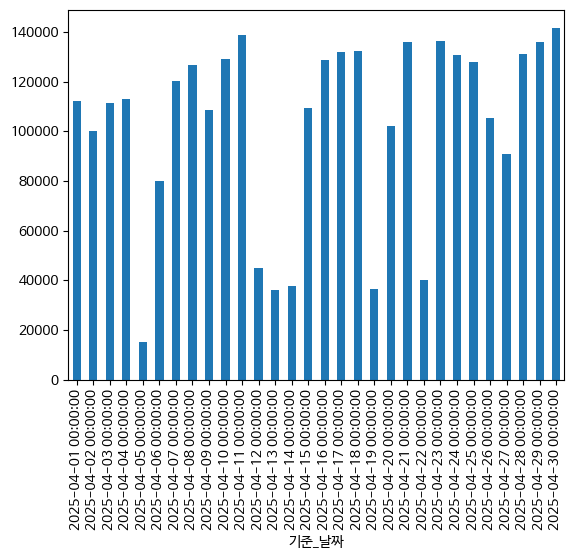

In [23]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [24]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2025_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12) # skiprows 12줄까지는 데이터 설명이어서 그 부분 제외하고 나머지 데이터 가져와라
rain_df.head(5)

,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2025-04-01,NaN,NaN,NaN,NaN
1,108,서울,2025-04-02,0.0,0.0,NaN,NaN
2,108,서울,2025-04-03,NaN,NaN,NaN,NaN
3,108,서울,2025-04-04,NaN,NaN,NaN,NaN
4,108,서울,2025-04-05,22.8,4.3,09:16,NaN


## 12-11 강수량 데이터 전처리

In [25]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

In [26]:
rain_df

,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,서울,2025-04-01,0.0,NaN,NaN
1,서울,2025-04-02,0.0,0.0,NaN
2,서울,2025-04-03,0.0,NaN,NaN
3,서울,2025-04-04,0.0,NaN,NaN
4,서울,2025-04-05,22.8,4.3,09:16
5,서울,2025-04-06,0.0,0.0,NaN
6,서울,2025-04-07,0.0,NaN,NaN
7,서울,2025-04-08,0.0,NaN,NaN
8,서울,2025-04-09,0.8,0.8,18:39
9,서울,2025-04-10,0.0,0.0,NaN


## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [27]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how='left', left_on='기준_날짜', right_on='일시')
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,112403,서울,2025-04-01,0.0,NaN,NaN
1,100310,서울,2025-04-02,0.0,0.0,NaN
2,111386,서울,2025-04-03,0.0,NaN,NaN
3,112966,서울,2025-04-04,0.0,NaN,NaN
4,15120,서울,2025-04-05,22.8,4.3,09:16


## 12-13 이용량 및 강수량 시각화

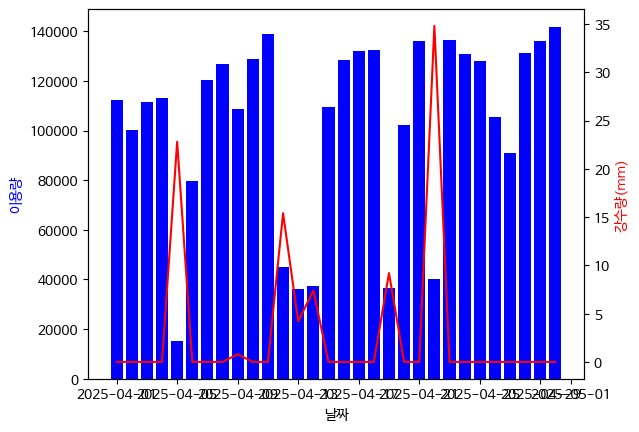

In [28]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'], color='b')

## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color='r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.49099731433338867


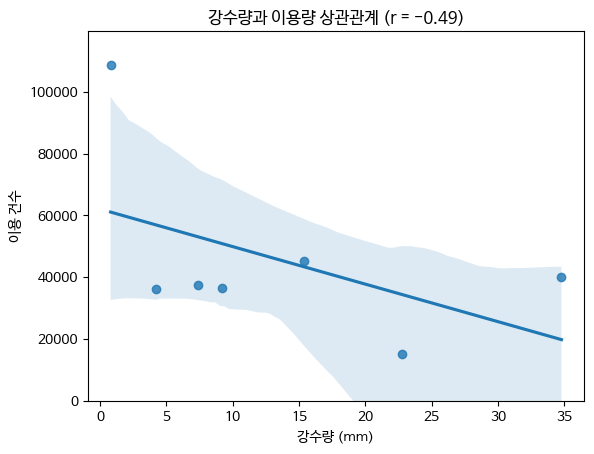

In [29]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x='강수량(mm)', y='이용량', data=merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [30]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True) # 괄호() 제거

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data=merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.588
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.263
Time:                        07:33:54   Log-Likelihood:                -80.447
No. Observations:                   7   AIC:                             164.9
Df Residuals:                       5   BIC:                             164.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.203e+04   1.68e+04      3.694      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
